# Centrality Measures

- Which nodes have the most connections?
- Which nodes influence others the most?
- Which nodes are critical for network communication?

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
import numpy as np

In [ ]:
# !mkdir data
# !wget https://snap.stanford.edu/data/facebook_combined.txt.gz
# !wget https://snap.stanford.edu/data/web-NotreDame.txt.gz
# !gunzip facebook_combined.txt.gz
# !gunzip web-NotreDame.txt.gz
# !mv facebook_combined.txt data/
# !mv web-NotreDame.txt data/
# !rm *.gz
# !sed -i '/^#/d' data/web-NotreDame.txt

## Centrality Measures

In [2]:
# Path to dataset
file_path = "../data/facebook_combined.txt"

# Load the graph as an undirected graph
G = nx.read_edgelist(file_path, nodetype=int, delimiter=' ')

# Number of nodes and edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Check if the graph is connected (for undirected graphs)
if nx.is_connected(G):
    print("The graph is connected.")
else:
    print("The graph is not connected.")


Number of nodes: 4039
Number of edges: 88234
The graph is connected.


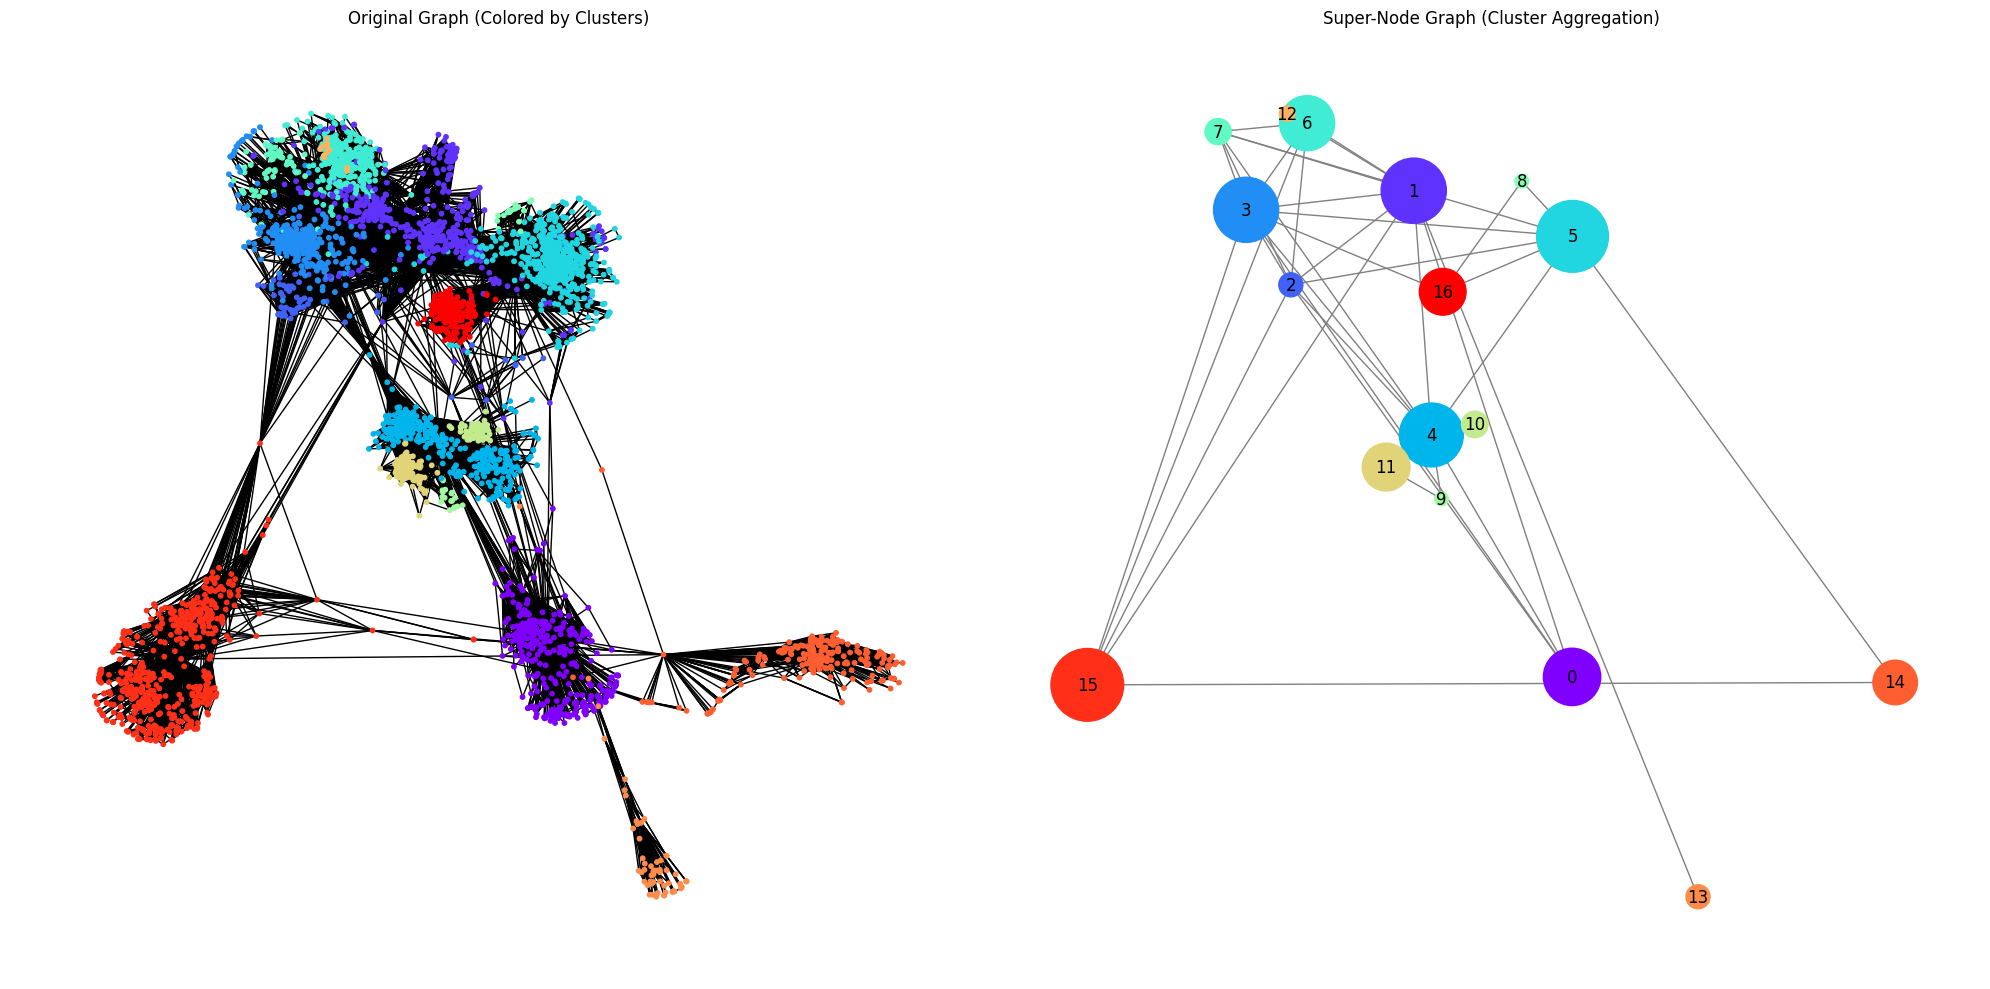

In [3]:
# Step 1: Detect Communities
partition = community_louvain.best_partition(G)

# Step 2: Create a Super-Node Graph
super_graph = nx.Graph()

# Group nodes by their cluster
clusters = defaultdict(list)
for node, cluster_id in partition.items():
    clusters[cluster_id].append(node)

# Add super-nodes and edges
for cluster_id, nodes in clusters.items():
    super_graph.add_node(cluster_id, size=len(nodes))

for u, v in G.edges():
    cluster_u = partition[u]
    cluster_v = partition[v]
    if cluster_u != cluster_v:
        super_graph.add_edge(cluster_u, cluster_v)

# Step 3: Generate a consistent layout
# Layout for the original graph
pos_original = nx.spring_layout(G)

# Layout for the super-node graph (average positions of clusters)
pos_super = {}
for cluster_id, nodes in clusters.items():
    # Compute the average position of nodes in the cluster
    cluster_positions = np.array([pos_original[node] for node in nodes])
    pos_super[cluster_id] = cluster_positions.mean(axis=0)

# Step 4: Visualize Both Graphs Side-by-Side with Consistent Layout
plt.figure(figsize=(20, 10))

# Subplot 1: Original Graph
plt.subplot(1, 2, 1)
original_node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos=pos_original, node_color=original_node_colors, cmap=plt.cm.rainbow, node_size=10, with_labels=False)
plt.title("Original Graph (Colored by Clusters)")

# Subplot 2: Super-Node Graph
plt.subplot(1, 2, 2)
node_sizes = [super_graph.nodes[n]['size'] * 5 for n in super_graph.nodes]
super_node_colors = [partition[next(iter(clusters[cluster_id]))] for cluster_id in super_graph.nodes()]  # Match cluster colors
nx.draw(super_graph, pos=pos_super, node_color=super_node_colors, cmap=plt.cm.rainbow, node_size=node_sizes, with_labels=True, edge_color='gray')
plt.title("Super-Node Graph (Cluster Aggregation)")

# Show the plots
plt.tight_layout()
plt.show()


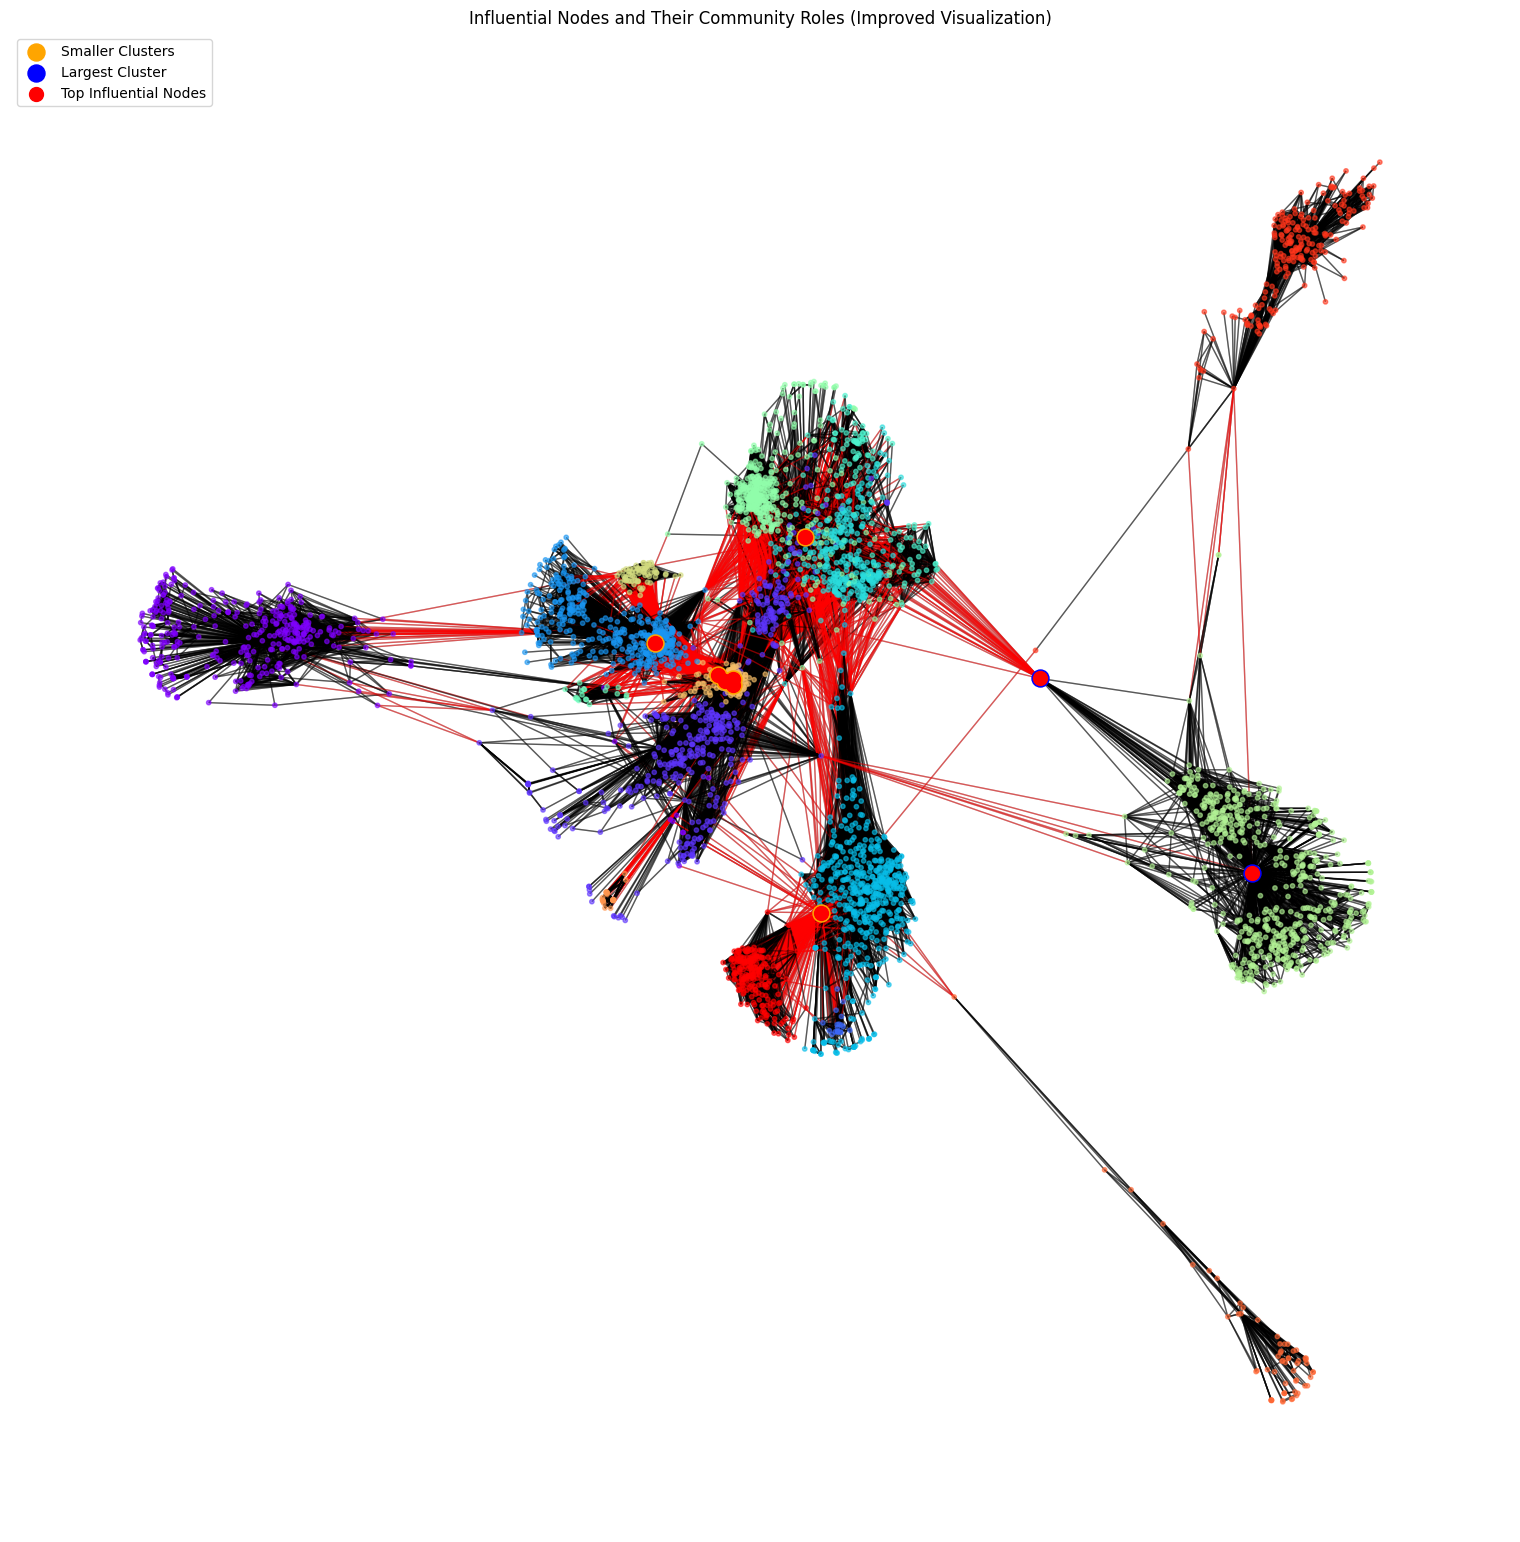

Which clusters (super-nodes) are the top influential nodes part of?
{2464: 11, 107: 8, 3437: 9, 1684: 4, 1912: 3, 2233: 11, 2266: 11, 1085: 9, 2206: 11}

Are these influential nodes concentrated in specific clusters or distributed?
Concentration per cluster:
{11: [2464, 2233, 2266, 2206], 8: [107], 9: [3437, 1085], 4: [1684], 3: [1912]}

Are globally influential nodes always within the largest communities?
Largest cluster ID: 9, Size: 548
Nodes in the largest cluster: [3437, 1085]
Nodes in smaller clusters: [2464, 107, 1684, 1912, 2233, 2266, 2206]

Do these nodes connect multiple communities?
Nodes involved in inter-community edges (red edges) are shown in the visualization.


In [4]:
# Step 1: Compute centrality measures
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
betweenness_centrality = nx.betweenness_centrality(G)

# Step 2: Identify top N influential nodes by eigenvector and betweenness centrality
N = 5
top_eigenvector_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:N]
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:N]

# Combine top nodes
top_nodes = set([node for node, _ in top_eigenvector_nodes] + [node for node, _ in top_betweenness_nodes])

# Step 3: Perform community detection
partition = community_louvain.best_partition(G)

# Map top nodes to their clusters
top_node_clusters = {node: partition[node] for node in top_nodes}

# Visualize the graph and explicitly answer questions
pos = nx.spring_layout(G)

# Define cluster sizes
cluster_sizes = defaultdict(int)
for cluster_id in partition.values():
    cluster_sizes[cluster_id] += 1

# Identify the largest cluster
largest_cluster_id = max(cluster_sizes, key=cluster_sizes.get)

# Visualization
plt.figure(figsize=(15, 15))

# 1. Plot the entire graph
node_colors = [partition[node] for node in G.nodes()]
nx.draw(
    G,
    pos,
    node_color=node_colors,
    cmap=plt.cm.rainbow,
    node_size=10,
    with_labels=False,
    edge_color="gray",
    alpha=0.6,
)

# 2. Highlight top nodes without repeated legend entries
top_nodes_drawn = False
largest_cluster_drawn = False
smaller_cluster_drawn = False

for node in top_nodes:
    cluster_id = partition[node]
    if cluster_id == largest_cluster_id:
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=[node],
            node_color="blue",
            node_size=150,
            label="Largest Cluster" if not largest_cluster_drawn else None,
        )
        largest_cluster_drawn = True
    else:
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=[node],
            node_color="orange",
            node_size=150,
            label="Smaller Clusters" if not smaller_cluster_drawn else None,
        )
        smaller_cluster_drawn = True

if not top_nodes_drawn:
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=top_nodes,
        node_color="red",
        node_size=100,
        label="Top Influential Nodes",
    )
    top_nodes_drawn = True

# 3. Highlight inter-community connections
edge_colors = ["black" if partition[u] == partition[v] else "red" for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.5)

plt.title("Influential Nodes and Their Community Roles (Improved Visualization)")
plt.legend(loc="upper left")
plt.show()

# Answer the questions explicitly
print("Which clusters (super-nodes) are the top influential nodes part of?")
print(top_node_clusters)

print("\nAre these influential nodes concentrated in specific clusters or distributed?")
print("Concentration per cluster:")
cluster_distribution = defaultdict(list)
for node, cluster in top_node_clusters.items():
    cluster_distribution[cluster].append(node)
print(dict(cluster_distribution))

print("\nAre globally influential nodes always within the largest communities?")
print(f"Largest cluster ID: {largest_cluster_id}, Size: {cluster_sizes[largest_cluster_id]}")
print("Nodes in the largest cluster:", [node for node, cluster in top_node_clusters.items() if cluster == largest_cluster_id])
print("Nodes in smaller clusters:", [node for node, cluster in top_node_clusters.items() if cluster != largest_cluster_id])

print("\nDo these nodes connect multiple communities?")
print("Nodes involved in inter-community edges (red edges) are shown in the visualization.")


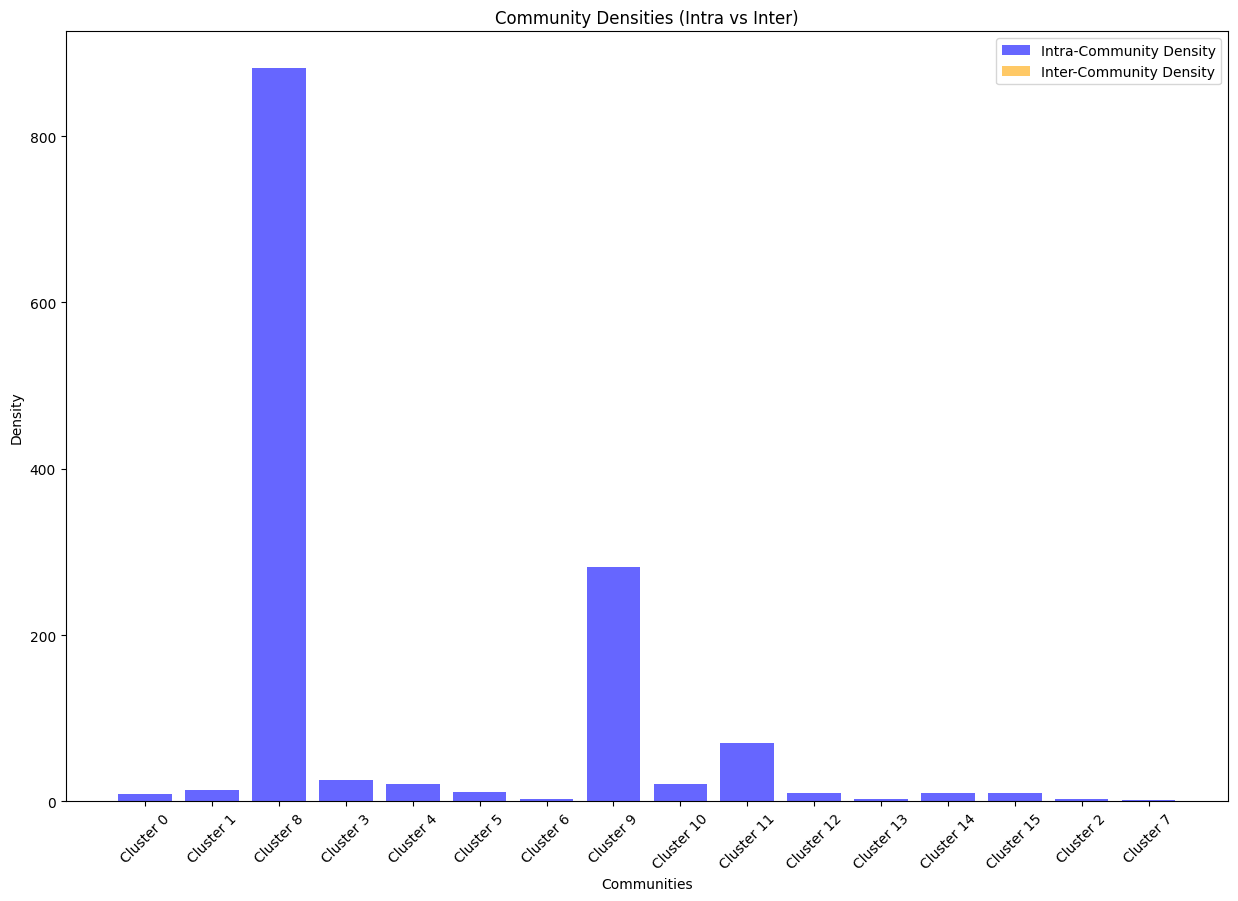

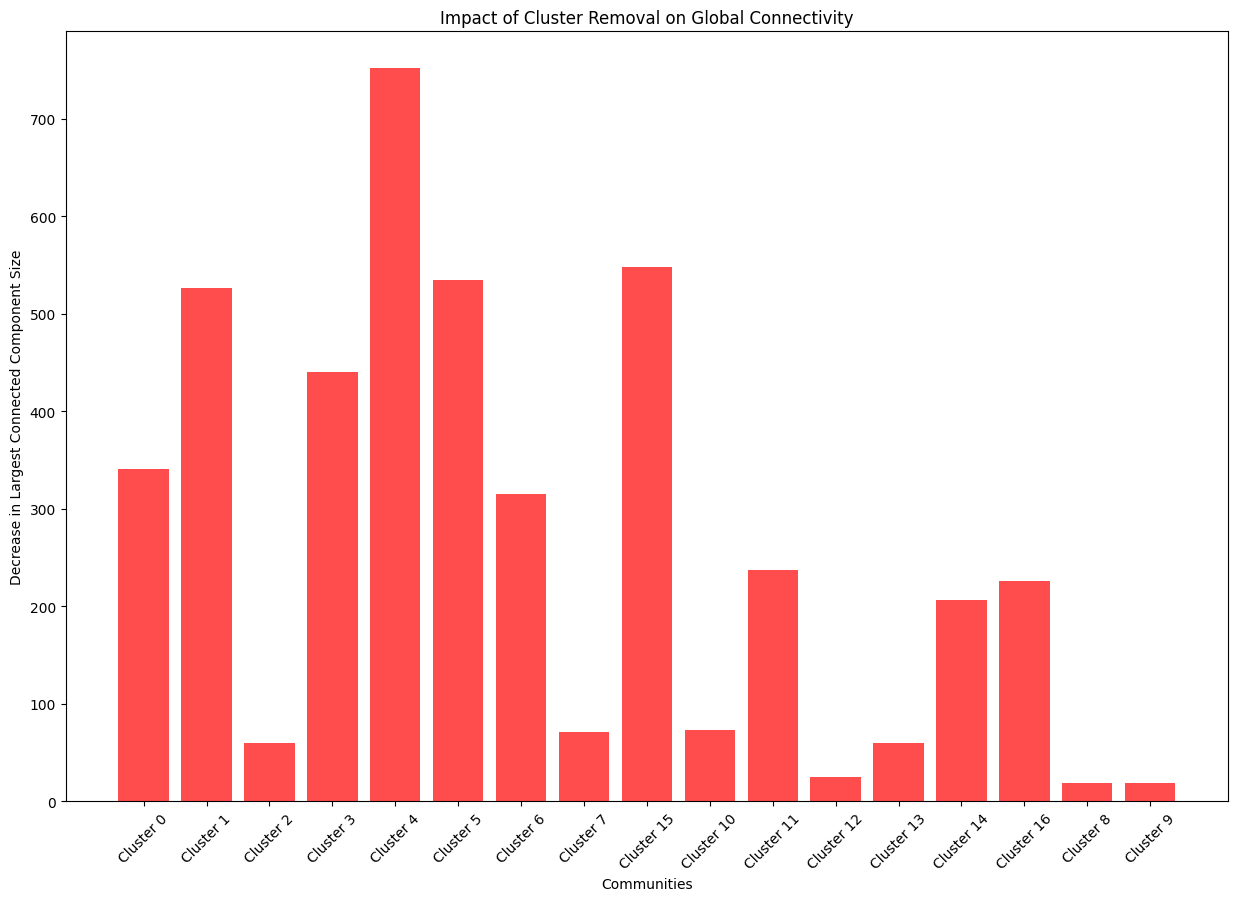

1. How does the removal of one community affect global connectivity?
Removing Cluster 0 reduces the largest connected component by 341 nodes.
Removing Cluster 1 reduces the largest connected component by 526 nodes.
Removing Cluster 2 reduces the largest connected component by 60 nodes.
Removing Cluster 3 reduces the largest connected component by 440 nodes.
Removing Cluster 4 reduces the largest connected component by 752 nodes.
Removing Cluster 5 reduces the largest connected component by 535 nodes.
Removing Cluster 6 reduces the largest connected component by 315 nodes.
Removing Cluster 7 reduces the largest connected component by 71 nodes.
Removing Cluster 15 reduces the largest connected component by 548 nodes.
Removing Cluster 10 reduces the largest connected component by 73 nodes.
Removing Cluster 11 reduces the largest connected component by 237 nodes.
Removing Cluster 12 reduces the largest connected component by 25 nodes.
Removing Cluster 13 reduces the largest connected compo

In [5]:
# 1. Treat each cluster as a super-node and compute inter/intra-community edges
cluster_edges = defaultdict(lambda: {'intra': 0, 'inter': 0})
total_edges = len(G.edges())

for u, v in G.edges():
    cluster_u = partition[u]
    cluster_v = partition[v]
    if cluster_u == cluster_v:
        cluster_edges[cluster_u]['intra'] += 1
    else:
        cluster_edges[cluster_u]['inter'] += 1
        cluster_edges[cluster_v]['inter'] += 1

# Normalize edge counts by the number of nodes in each community
intra_density = {cluster: data['intra'] / len(clusters[cluster]) for cluster, data in cluster_edges.items()}
inter_density = {cluster: data['inter'] / total_edges for cluster, data in cluster_edges.items()}

# Identify the largest connected component after community removal
global_connectivity_impact = {}
original_lcc_size = len(max(nx.connected_components(G), key=len))

for cluster_id in clusters.keys():
    # Remove all nodes in this cluster
    G_temp = G.copy()
    G_temp.remove_nodes_from(clusters[cluster_id])
    lcc_size = len(max(nx.connected_components(G_temp), key=len))
    global_connectivity_impact[cluster_id] = original_lcc_size - lcc_size

# Visualize inter and intra-community densities
plt.figure(figsize=(15, 10))
plt.bar(range(len(intra_density)), list(intra_density.values()), color='blue', alpha=0.6, label='Intra-Community Density')
plt.bar(range(len(inter_density)), list(inter_density.values()), color='orange', alpha=0.6, label='Inter-Community Density')
plt.xticks(range(len(intra_density)), [f"Cluster {i}" for i in intra_density.keys()], rotation=45)
plt.title("Community Densities (Intra vs Inter)")
plt.xlabel("Communities")
plt.ylabel("Density")
plt.legend()
plt.show()

# Visualize the impact of removing clusters
plt.figure(figsize=(15, 10))
plt.bar(range(len(global_connectivity_impact)), list(global_connectivity_impact.values()), color='red', alpha=0.7)
plt.xticks(range(len(global_connectivity_impact)), [f"Cluster {i}" for i in global_connectivity_impact.keys()], rotation=45)
plt.title("Impact of Cluster Removal on Global Connectivity")
plt.xlabel("Communities")
plt.ylabel("Decrease in Largest Connected Component Size")
plt.show()

# Answer questions explicitly
print("1. How does the removal of one community affect global connectivity?")
for cluster, impact in global_connectivity_impact.items():
    print(f"Removing Cluster {cluster} reduces the largest connected component by {impact} nodes.")

print("\n2. Which communities are key for maintaining the graph's integrity?")
critical_clusters = [cluster for cluster, impact in global_connectivity_impact.items() if impact > 0.1 * original_lcc_size]
print(f"Critical communities are: {critical_clusters} (contributing significantly to global connectivity).")


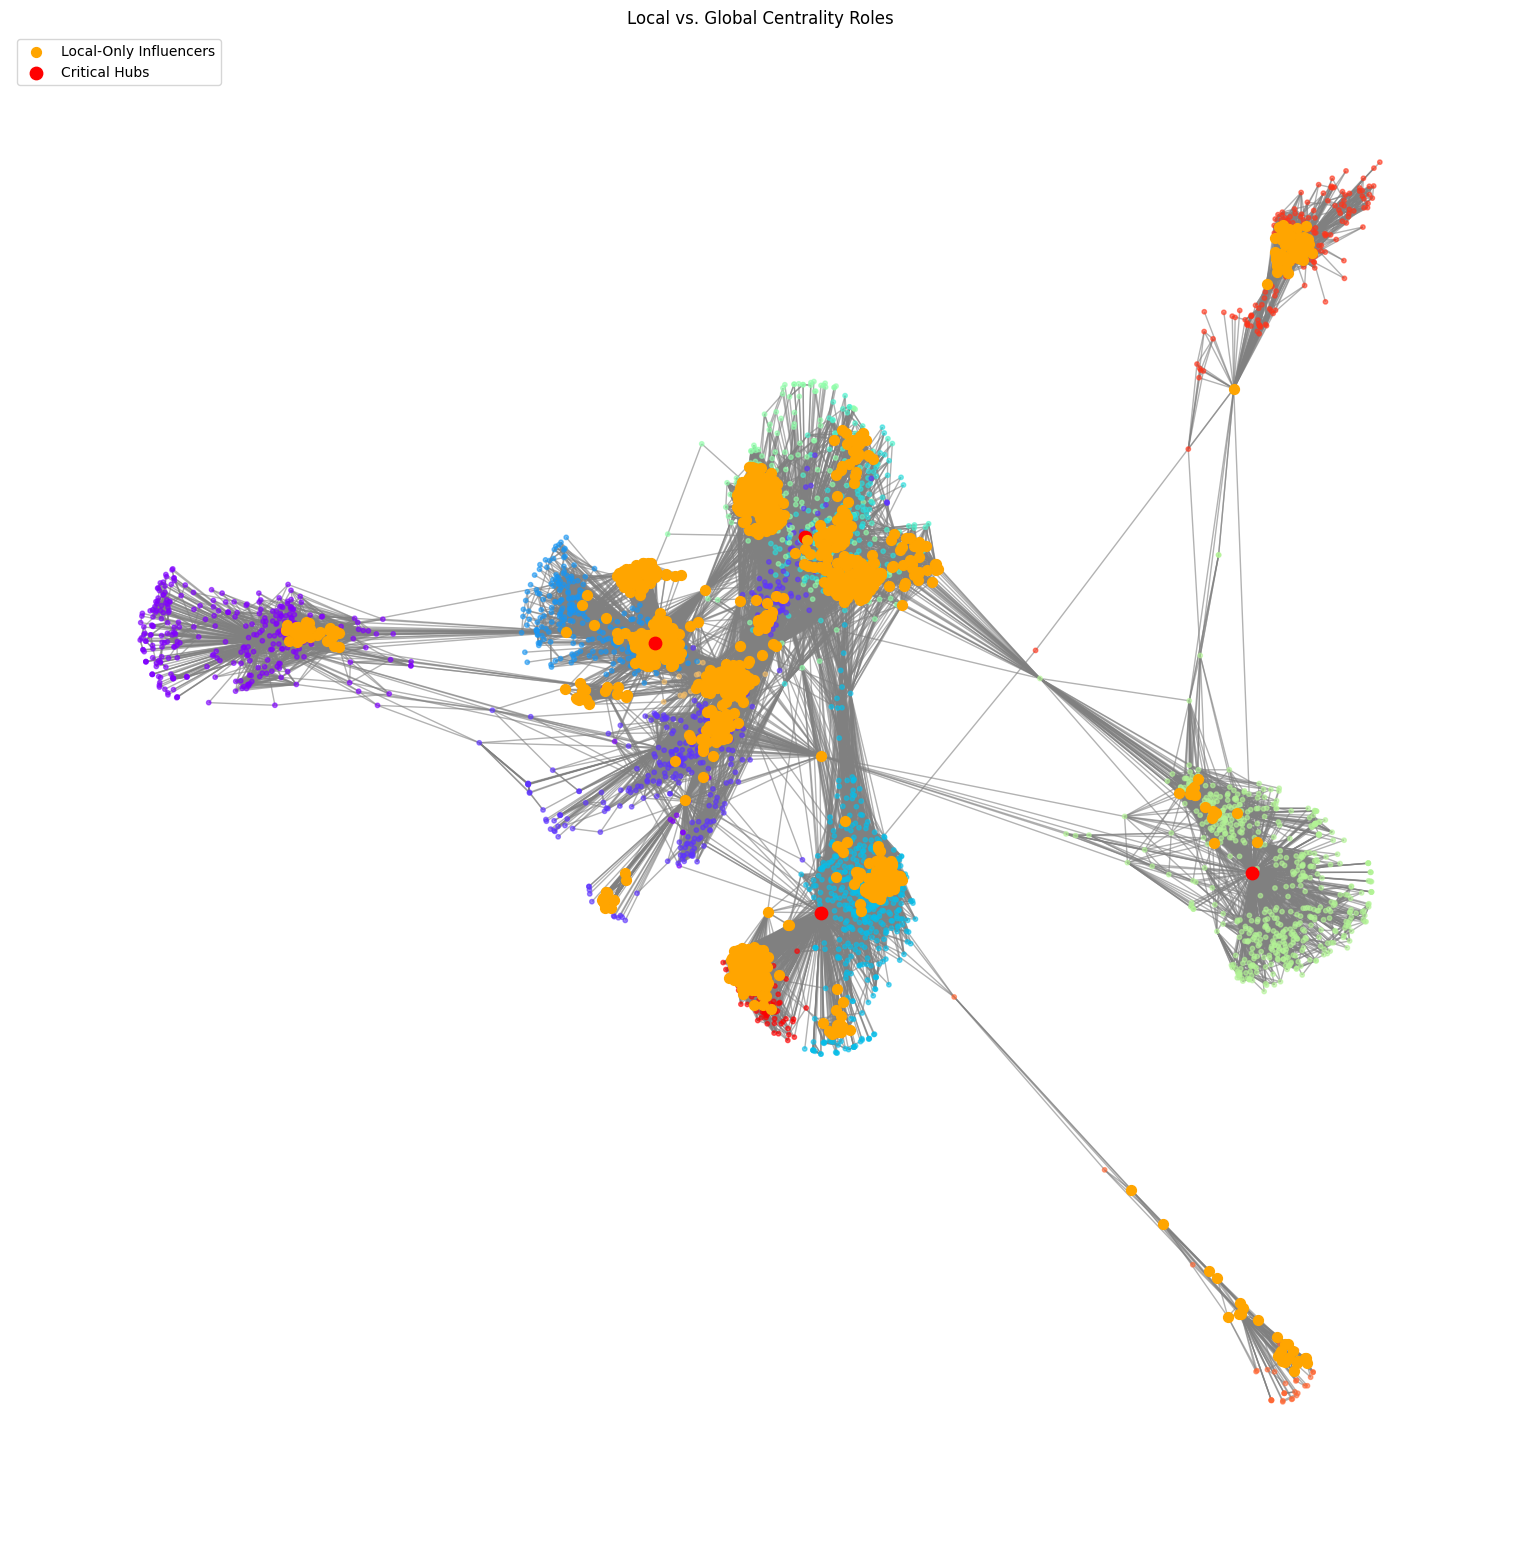

1. Are global hubs also the most central nodes locally, or do local and global roles diverge?
Cluster 0:
  Critical Hubs: []
  Number of Local-Only Influencers: 40
Cluster 1:
  Critical Hubs: []
  Number of Local-Only Influencers: 86
Cluster 8:
  Critical Hubs: [107]
  Number of Local-Only Influencers: 265
Cluster 3:
  Critical Hubs: [1912]
  Number of Local-Only Influencers: 184
Cluster 4:
  Critical Hubs: [1684]
  Number of Local-Only Influencers: 106
Cluster 5:
  Critical Hubs: []
  Number of Local-Only Influencers: 177
Cluster 6:
  Critical Hubs: []
  Number of Local-Only Influencers: 71
Cluster 9:
  Critical Hubs: [3437]
  Number of Local-Only Influencers: 15
Cluster 10:
  Critical Hubs: []
  Number of Local-Only Influencers: 73
Cluster 11:
  Critical Hubs: []
  Number of Local-Only Influencers: 209
Cluster 12:
  Critical Hubs: []
  Number of Local-Only Influencers: 25
Cluster 13:
  Critical Hubs: []
  Number of Local-Only Influencers: 29
Cluster 14:
  Critical Hubs: []
  Number o

In [6]:
# Group nodes by their cluster from the partition
clusters = defaultdict(list)
for node, cluster_id in partition.items():
    clusters[cluster_id].append(node)

# 1. Compute local centralities for each community
local_centralities = {}
for cluster_id, nodes in clusters.items():
    # Create a subgraph for the current community
    community_subgraph = G.subgraph(nodes)
    local_centralities[cluster_id] = {
        "degree": nx.degree_centrality(community_subgraph),
        "clustering": nx.clustering(community_subgraph),
    }

# 2. Compare local and global roles
global_degree_centrality = nx.degree_centrality(G)
global_clustering_coefficient = nx.clustering(G)

# Identify nodes with high local centrality but low global centrality (local influencers)
local_only_influencers = defaultdict(list)
critical_hubs = defaultdict(list)

for cluster_id, nodes in clusters.items():
    for node in nodes:
        # Define thresholds to identify significant nodes
        local_degree = local_centralities[cluster_id]["degree"].get(node, 0)
        global_degree = global_degree_centrality.get(node, 0)
        local_clustering = local_centralities[cluster_id]["clustering"].get(node, 0)
        global_clustering = global_clustering_coefficient.get(node, 0)

        if local_degree > 0.1 and global_degree < 0.05:
            local_only_influencers[cluster_id].append(node)
        if local_degree > 0.1 and global_degree > 0.1:
            critical_hubs[cluster_id].append(node)

# Improved Visualization: Local-Only Influencers and Critical Hubs without Color Overlap
plt.figure(figsize=(15, 15))

# Plot the entire graph with default community colors for regular nodes
regular_node_colors = [partition[node] for node in G.nodes()]
nx.draw(
    G,
    pos,
    node_color=regular_node_colors,
    cmap=plt.cm.rainbow,
    node_size=10,
    with_labels=False,
    edge_color="gray",
    alpha=0.6,
)

# Highlight local-only influencers and critical hubs with distinct colors
local_influencers_drawn = False
critical_hubs_drawn = False

for cluster_id, nodes in clusters.items():
    if cluster_id in local_only_influencers and len(local_only_influencers[cluster_id]) > 0:
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=local_only_influencers[cluster_id],
            node_color="orange",
            node_size=50,
            label="Local-Only Influencers" if not local_influencers_drawn else None,
        )
        local_influencers_drawn = True

    if cluster_id in critical_hubs and len(critical_hubs[cluster_id]) > 0:
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=critical_hubs[cluster_id],
            node_color="red",
            node_size=80,
            label="Critical Hubs" if not critical_hubs_drawn else None,
        )
        critical_hubs_drawn = True

plt.title("Local vs. Global Centrality Roles")
plt.legend(loc="upper left")
plt.show()

# Explicitly Answer Questions
print("1. Are global hubs also the most central nodes locally, or do local and global roles diverge?")
for cluster_id in clusters.keys():
    print(f"Cluster {cluster_id}:")
    print(f"  Critical Hubs: {critical_hubs[cluster_id] if cluster_id in critical_hubs else []}")
    print(f"  Number of Local-Only Influencers: {len(local_only_influencers[cluster_id] if cluster_id in local_only_influencers else [])}")

print("\n2. Which clusters are dominated by local-only influencers, and which have globally important nodes?")
for cluster_id in clusters.keys():
    critical_count = len(critical_hubs[cluster_id]) if cluster_id in critical_hubs else 0
    local_count = len(local_only_influencers[cluster_id]) if cluster_id in local_only_influencers else 0

    if local_count > critical_count:
        print(f"Cluster {cluster_id} is dominated by local-only influencers.")
    else:
        print(f"Cluster {cluster_id} has a significant number of globally important nodes.")


## HITS Algorithm

In [ ]:
# Path to dataset
file_path = "../data/web-NotreDame.txt"

# Load the graph as an undirected graph
G = nx.read_edgelist(file_path, nodetype=int, delimiter='\t', create_using=nx.DiGraph)

# Number of nodes and edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print()

# Extract k-core of the graph
k = 12
G.remove_edges_from(nx.selfloop_edges(G))
G_kcore = nx.k_core(G, k)
# Number of nodes and edges
print("Number of nodes in the k-core:", G_kcore.number_of_nodes())
print("Number of edges in the k-core:", G_kcore.number_of_edges())
print()

# Extract the largest SCC
largest_scc = max(nx.strongly_connected_components(G_kcore), key=len)
G_scc = G_kcore.subgraph(largest_scc).copy()

# Number of nodes and edges
print("Number of nodes:", G_scc.number_of_nodes())
print("Number of edges:", G_scc.number_of_edges())
print()

Number of nodes: 325729
Number of edges: 1497134

Number of nodes in the k-core: 24202
Number of edges in the k-core: 714017

Number of nodes: 3562
Number of edges: 45677



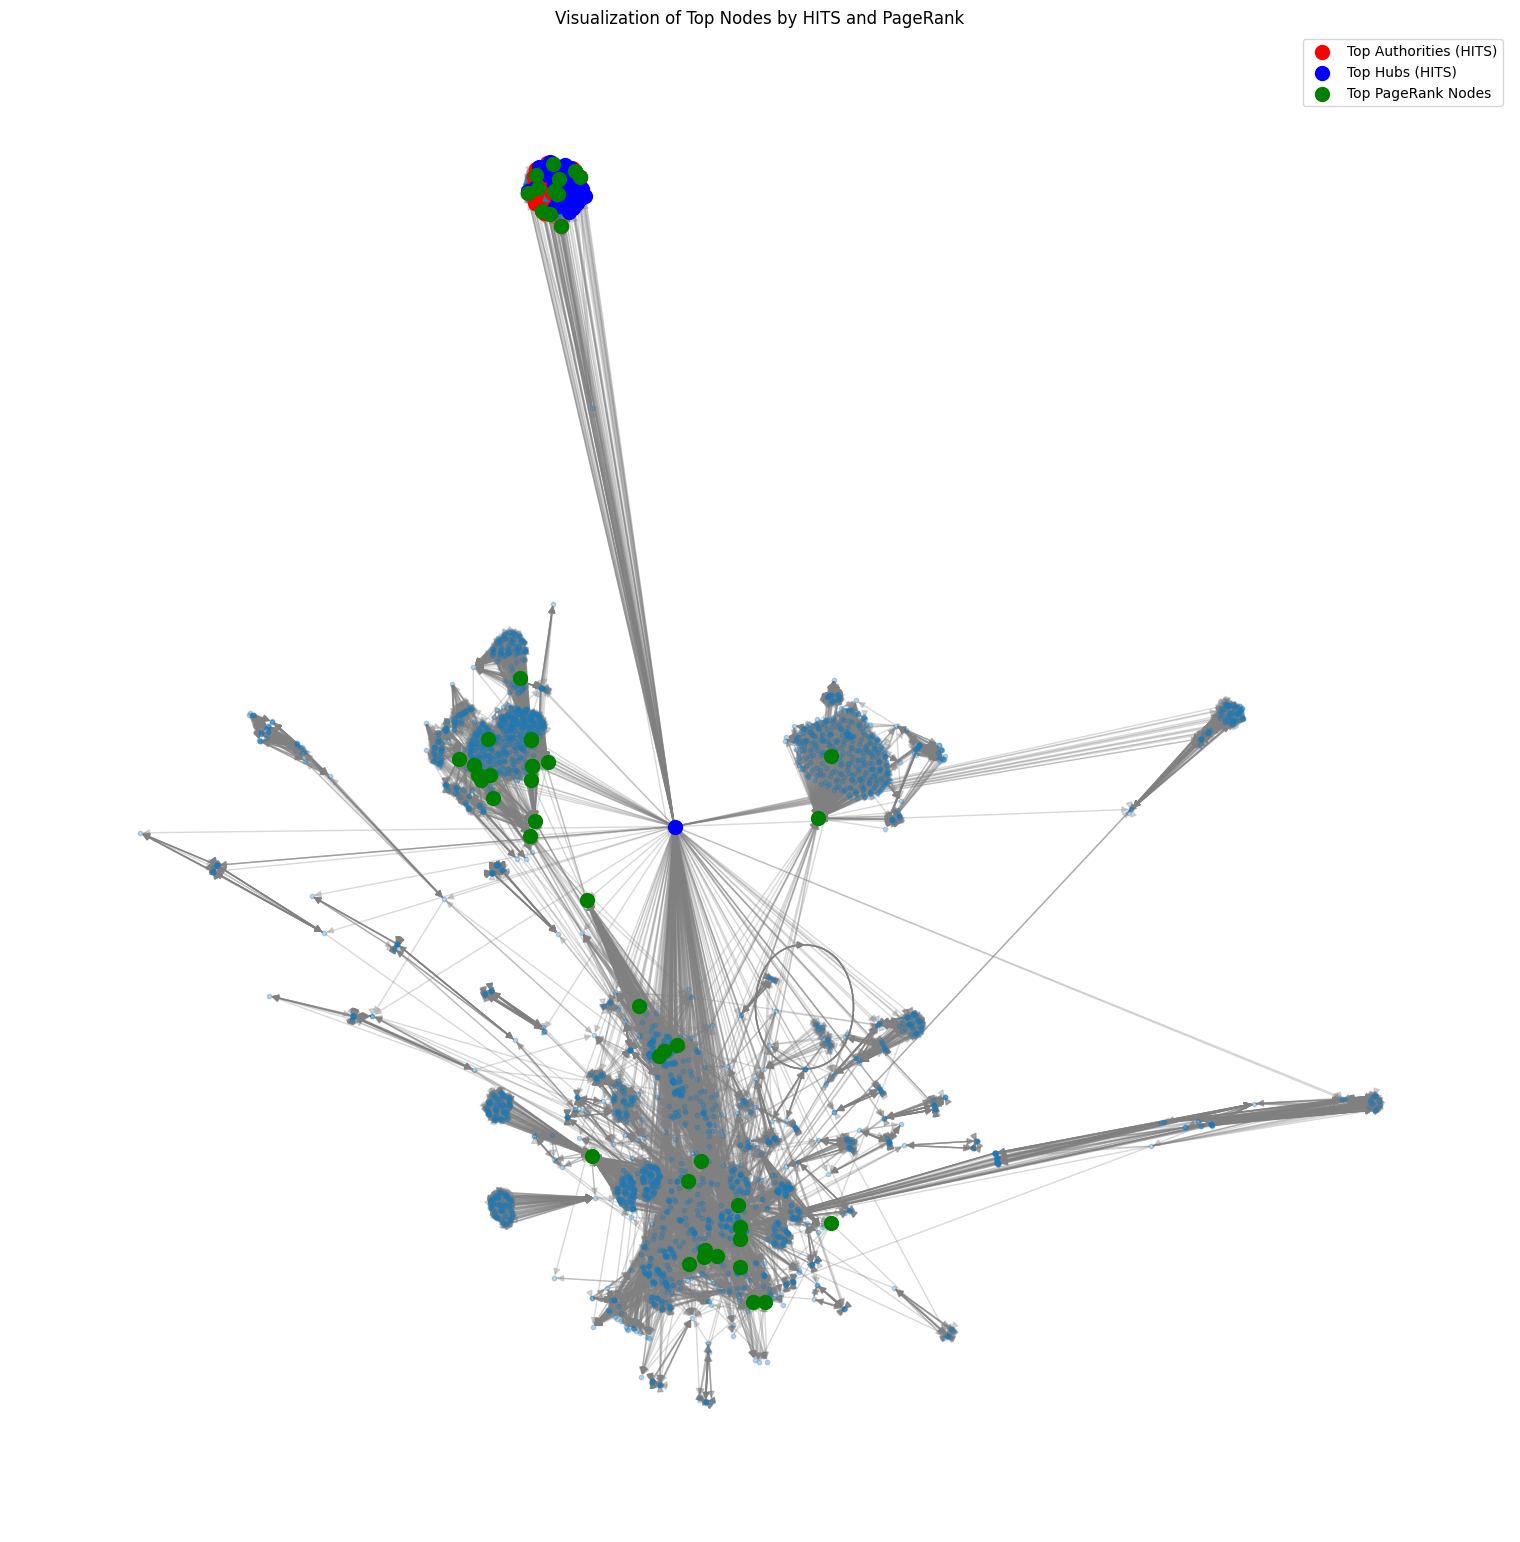

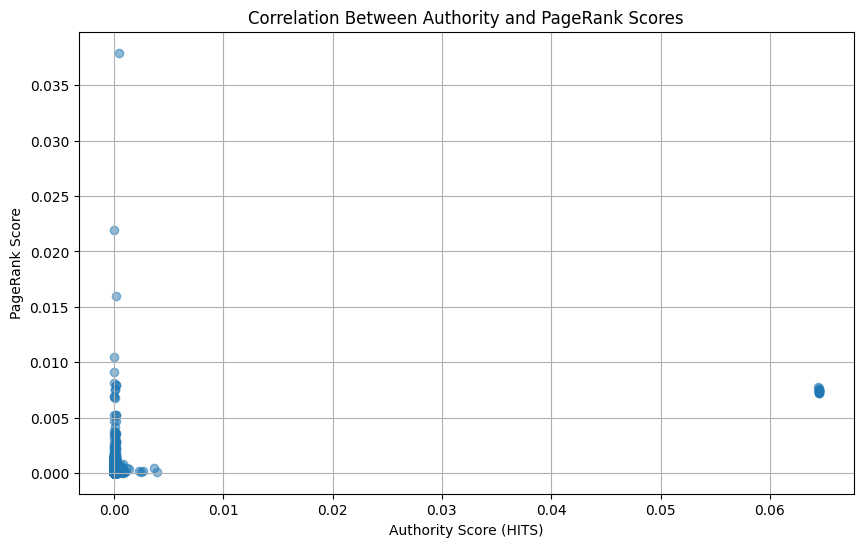

1. Are high PageRank nodes also high authorities in HITS?
Number of overlapping nodes between top authorities and PageRank: 13
Nodes: {25766, 25767, 25768, 25734, 25735, 25799, 25800, 25805, 25774, 25723, 25722, 25787, 25788}

2. Are high hubs correlated with high PageRank?
Number of overlapping nodes between top hubs and PageRank: 0
Nodes: set()

3. Do top nodes (authorities, hubs, PageRank) form dense clusters or act as bridges?
Number of nodes in authority subgraph: 50
Number of nodes in hub subgraph: 50
Number of nodes in PageRank subgraph: 50


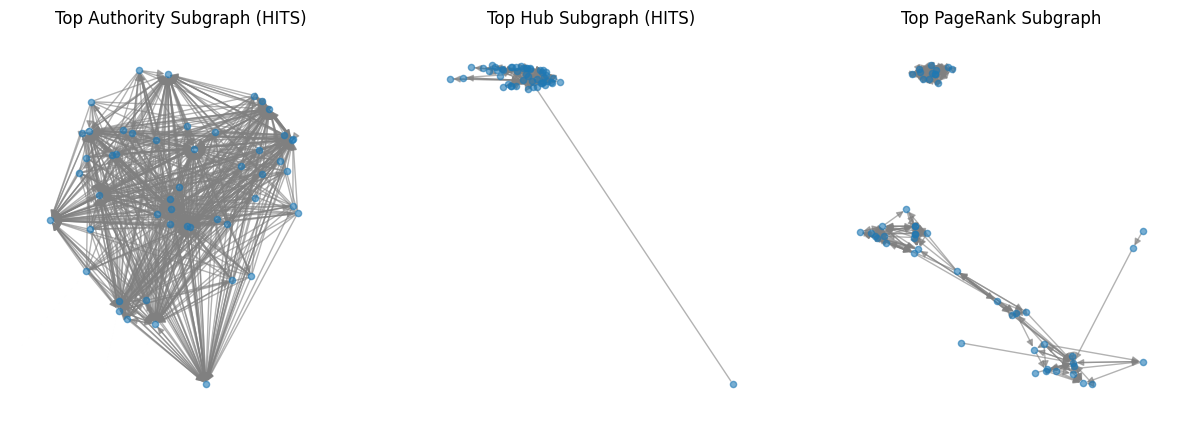

In [8]:
# Step 2: Compute HITS and PageRank
# Compute HITS scores
hits_scores = nx.hits(G_scc, max_iter=1000)
authority_scores = hits_scores[1]
hub_scores = hits_scores[0]
# Compute PageRank scores
pagerank_scores = nx.pagerank(G_scc)

# Step 3: Select Top 50 Nodes by each metric
N = 50
top_authorities = sorted(authority_scores.items(), key=lambda x: x[1], reverse=True)[:N]
top_hubs = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)[:N]
top_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:N]
# Combine all top nodes
top_nodes = set([node for node, _ in top_authorities + top_hubs + top_pagerank])
# Map scores for visualization
authority_dict = dict(top_authorities)
hub_dict = dict(top_hubs)
pagerank_dict = dict(top_pagerank)

# Step 4: Visualizations and Answers
pos = nx.spring_layout(G_scc)
# Visualization 1: Highlight Top Nodes in Graph
plt.figure(figsize=(15, 15))
# Regular graph visualization
nx.draw(G_scc, pos, node_size=10, edge_color="gray", alpha=0.3, with_labels=False)
# Highlight top authorities
nx.draw_networkx_nodes(
    G_scc,
    pos,
    nodelist=authority_dict.keys(),
    node_color="red",
    node_size=100,
    label="Top Authorities (HITS)",
)
# Highlight top hubs
nx.draw_networkx_nodes(
    G_scc,
    pos,
    nodelist=hub_dict.keys(),
    node_color="blue",
    node_size=100,
    label="Top Hubs (HITS)",
)
# Highlight top PageRank nodes
nx.draw_networkx_nodes(
    G_scc,
    pos,
    nodelist=pagerank_dict.keys(),
    node_color="green",
    node_size=100,
    label="Top PageRank Nodes",
)
plt.legend(loc="upper right")
plt.title("Visualization of Top Nodes by HITS and PageRank")
plt.show()
# Scatter Plot: Authority vs. PageRank
authority_scores_full = list(authority_scores.values())
pagerank_scores_full = list(pagerank_scores.values())
plt.figure(figsize=(10, 6))
plt.scatter(authority_scores_full, pagerank_scores_full, alpha=0.5)
plt.xlabel("Authority Score (HITS)")
plt.ylabel("PageRank Score")
plt.title("Correlation Between Authority and PageRank Scores")
plt.grid(True)
plt.show()
# Overlap Analysis
overlap_authority_pagerank = set(authority_dict.keys()) & set(pagerank_dict.keys())
overlap_hub_pagerank = set(hub_dict.keys()) & set(pagerank_dict.keys())

# Answers to Questions
print("1. Are high PageRank nodes also high authorities in HITS?")
print(
    f"Number of overlapping nodes between top authorities and PageRank: {len(overlap_authority_pagerank)}"
)
print(f"Nodes: {overlap_authority_pagerank}")

print("\n2. Are high hubs correlated with high PageRank?")
print(
    f"Number of overlapping nodes between top hubs and PageRank: {len(overlap_hub_pagerank)}"
)
print(f"Nodes: {overlap_hub_pagerank}")

print(
    "\n3. Do top nodes (authorities, hubs, PageRank) form dense clusters or act as bridges?"
)
# Extract subgraphs centered around top nodes for each metric
authority_subgraph = G_scc.subgraph(authority_dict.keys())
hub_subgraph = G_scc.subgraph(hub_dict.keys())
pagerank_subgraph = G_scc.subgraph(pagerank_dict.keys())

print(f"Number of nodes in authority subgraph: {authority_subgraph.number_of_nodes()}")
print(f"Number of nodes in hub subgraph: {hub_subgraph.number_of_nodes()}")
print(f"Number of nodes in PageRank subgraph: {pagerank_subgraph.number_of_nodes()}")

# Visualize subgraph densities
plt.figure(figsize=(15, 5))

# Authority subgraph
plt.subplot(1, 3, 1)
nx.draw(
    authority_subgraph,
    pos,
    node_size=20,
    edge_color="gray",
    alpha=0.6,
    with_labels=False,
)
plt.title("Top Authority Subgraph (HITS)")

# Hub subgraph
plt.subplot(1, 3, 2)
nx.draw(
    hub_subgraph, pos, node_size=20, edge_color="gray", alpha=0.6, with_labels=False
)
plt.title("Top Hub Subgraph (HITS)")

# PageRank subgraph
plt.subplot(1, 3, 3)
nx.draw(
    pagerank_subgraph,
    pos,
    node_size=20,
    edge_color="gray",
    alpha=0.6,
    with_labels=False,
)
plt.title("Top PageRank Subgraph")

plt.show()

Local vs. Global Influence and Structural Significance of Top Nodes:
Top Authority (25787):
  Betweenness Centrality: 0.0
  Clustering Coefficient: 0.04853007875314394
  Degree: 540
Top Hub (7137):
  Betweenness Centrality: 0.3264725961435668
  Clustering Coefficient: 0.02118964376830766
  Degree: 412
Top PageRank (0):
  Betweenness Centrality: 0.6448385560912919
  Clustering Coefficient: 0.010363530866066248
  Degree: 1091


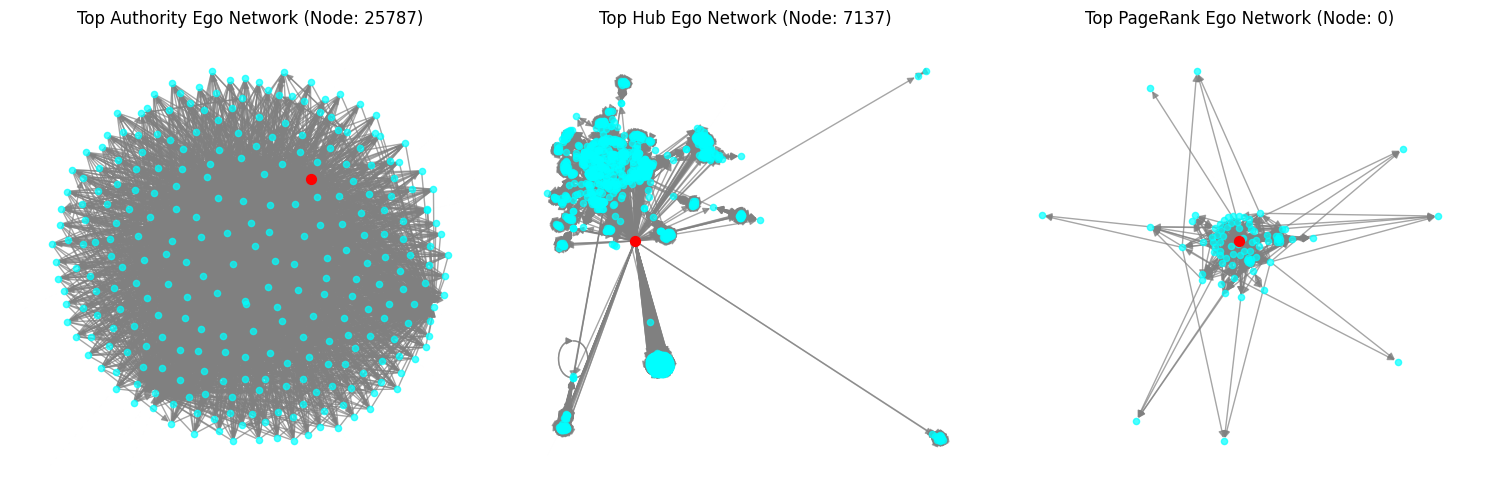

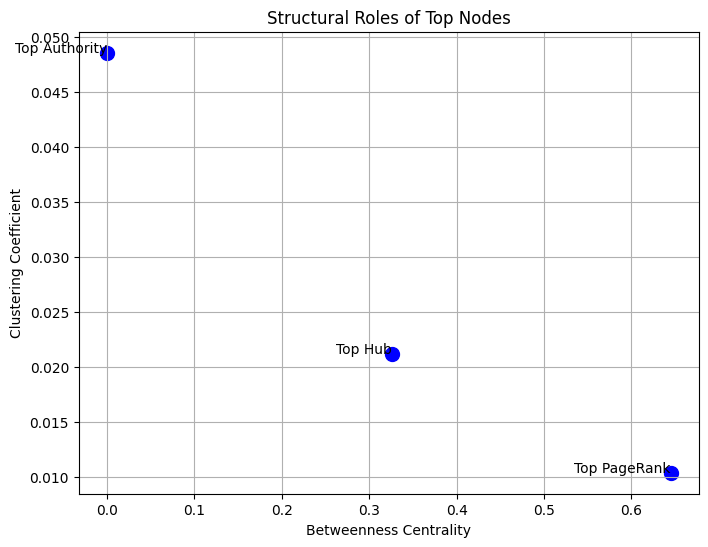

In [15]:
# Compute Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G_scc)

# Compute Clustering Coefficients
clustering_coefficients = nx.clustering(G_scc)

# Extract properties for top nodes (authority, hub, pagerank)
top_authority_node = top_authorities[0][0]
top_hub_node = top_hubs[0][0]
top_pagerank_node = top_pagerank[0][0]

top_nodes = {
    "Top Authority": top_authority_node,
    "Top Hub": top_hub_node,
    "Top PageRank": top_pagerank_node,
}

# Analyze and print local/global influence and structural significance
analysis_results = {}
for role, node in top_nodes.items():
    analysis_results[role] = {
        "Betweenness Centrality": betweenness_centrality.get(node, 0),
        "Clustering Coefficient": clustering_coefficients.get(node, 0),
        "Degree": G_scc.degree[node],
    }

print("Local vs. Global Influence and Structural Significance of Top Nodes:")
for role, metrics in analysis_results.items():
    print(f"{role} ({top_nodes[role]}):")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

# Visualize Neighborhoods and Influence
plt.figure(figsize=(15, 5))

for i, (role, node) in enumerate(top_nodes.items(), 1):
    ego_network = nx.ego_graph(G_scc, node, radius=2)
    pos = nx.spring_layout(ego_network)
    plt.subplot(1, 3, i)
    nx.draw(
        ego_network,
        pos,
        node_color="cyan",
        node_size=20,
        edge_color="gray",
        with_labels=False,
        alpha=0.7,
    )
    nx.draw_networkx_nodes(
        ego_network,
        pos,
        nodelist=[node],
        node_color="red",
        node_size=50,
        label=f"{role} Node",
    )
    plt.title(f"{role} Ego Network (Node: {node})")

plt.tight_layout()
plt.show()

# Visualize Correlation between Betweenness Centrality and Clustering Coefficient for Top Nodes
betweenness_values = [
    metrics["Betweenness Centrality"] for metrics in analysis_results.values()
]
clustering_values = [
    metrics["Clustering Coefficient"] for metrics in analysis_results.values()
]

plt.figure(figsize=(8, 6))
plt.scatter(betweenness_values, clustering_values, color="blue", s=100)
for i, role in enumerate(top_nodes.keys()):
    plt.text(
        betweenness_values[i],
        clustering_values[i],
        role,
        fontsize=10,
        ha="right",
        color="black",
    )
plt.xlabel("Betweenness Centrality")
plt.ylabel("Clustering Coefficient")
plt.title("Structural Roles of Top Nodes")
plt.grid(True)
plt.show()

Community Impact Analysis of Top Nodes:
Top Authority (25787):
  Community ID: 47
  Community Size: 529
  Community Density: 0.02796514292260984
  Inter-Community Edges: 324
Top Hub (7137):
  Community ID: 47
  Community Size: 529
  Community Density: 0.02796514292260984
  Inter-Community Edges: 324
Top PageRank (0):
  Community ID: 0
  Community Size: 226
  Community Density: 0.0496165191740413
  Inter-Community Edges: 113


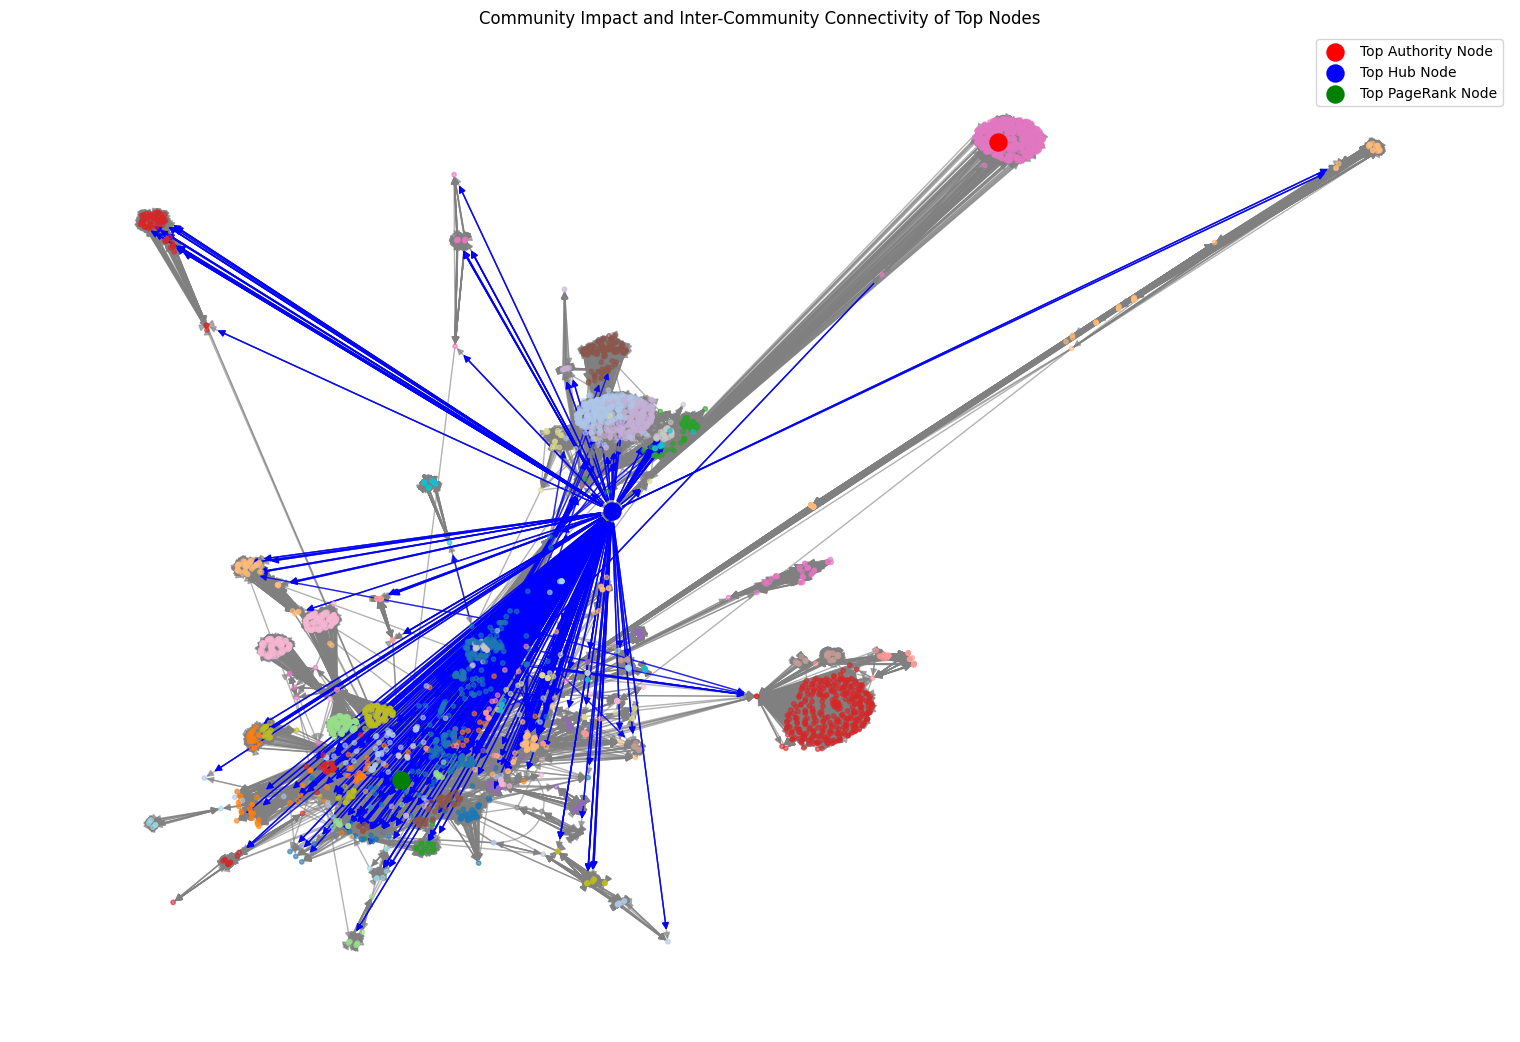

In [14]:
# Compute communities using Label Propagation for directed graphs
communities = nx.community.asyn_lpa_communities(G_scc.to_undirected(), weight="weight")

# Map nodes to their community IDs
partition = {}
for community_id, nodes in enumerate(communities):
    for node in nodes:
        partition[node] = community_id


# Group nodes by community
communities = defaultdict(list)
for node, comm in partition.items():
    communities[comm].append(node)

# Analyze top nodes' communities
top_nodes = {
    "Top Authority": top_authorities[0][0],
    "Top Hub": top_hubs[0][0],
    "Top PageRank": top_pagerank[0][0],
}

community_analysis = {}
for role, node in top_nodes.items():
    community_id = partition[node]
    community_nodes = communities[community_id]
    community_subgraph = G_scc.subgraph(community_nodes)
    community_density = nx.density(community_subgraph)
    inter_community_edges = sum(
        1 for u, v in G_scc.edges(community_nodes) if partition[u] != partition[v]
    )

    community_analysis[role] = {
        "Community ID": community_id,
        "Community Size": len(community_nodes),
        "Community Density": community_density,
        "Inter-Community Edges": inter_community_edges,
    }

# Print analysis results
print("Community Impact Analysis of Top Nodes:")
for role, metrics in community_analysis.items():
    print(f"{role} ({top_nodes[role]}):")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

# Visualization: Inter-Community Connectivity
plt.figure(figsize=(15, 10))

# Visualize the entire graph with community coloring
node_colors = [partition[node] for node in G_scc.nodes()]
pos = nx.spring_layout(G_scc)
nx.draw(
    G_scc,
    pos,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    node_size=10,
    edge_color="gray",
    with_labels=False,
    alpha=0.6,
)

# Assign distinct colors to top nodes
top_node_colors = {
    "Top Authority": "red",
    "Top Hub": "blue",
    "Top PageRank": "green",
}

# Highlight top nodes with unique colors
for role, node in top_nodes.items():
    nx.draw_networkx_nodes(
        G_scc,
        pos,
        nodelist=[node],
        node_color=top_node_colors[role],
        node_size=150,
        label=f"{role} Node",
    )

# Highlight inter-community connections with blue edges
for role, node in top_nodes.items():
    community_id = partition[node]
    for u, v in G_scc.edges():
        if partition[u] == community_id and partition[v] != community_id:
            nx.draw_networkx_edges(
                G_scc, pos, edgelist=[(u, v)], edge_color="blue", alpha=0.8, width=1
            )

# Add a title and legend
plt.title("Community Impact and Inter-Community Connectivity of Top Nodes")
plt.legend(loc="upper right")
plt.show()